In [1]:
%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sb

from typing import List

In [2]:
figsize_default = (10, 6)

In [3]:
sys.path.append(Path.cwd().parent.as_posix())
print(sys.path)

['/home/alex/.pyenv/versions/3.13.2/lib/python313.zip', '/home/alex/.pyenv/versions/3.13.2/lib/python3.13', '/home/alex/.pyenv/versions/3.13.2/lib/python3.13/lib-dynload', '', '/home/alex/code/sms_spam_classification/.venv/lib/python3.13/site-packages', '/home/alex/code/sms_spam_classification']


## Loading data and some EDA

In [4]:
data_path = Path.cwd() / ".." / "data" / "SMSSpamCollection"

In [5]:
# have a first rough look into the format (also described in readme)
!cat -A $data_path | head -n 10

ham^IGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...$
ham^IOk lar... Joking wif u oni...$
spam^IFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's$
ham^IU dun say so early hor... U c already then say...$
ham^INah I don't think he goes to usf, he lives around here though$
spam^IFreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, M-BM-#1.50 to rcv$
ham^IEven my brother is not like to speak with me. They treat me like aids patent.$
ham^IAs per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune$
spam^IWINNER!! As a valued network customer you have been selected to receivea M-BM-#900 prize reward! To claim call 09061701461. Claim code KL341. 

* In our version of the data, there were two entries with space instead of tab delimiter, which we manually fixed before loading the data further. That might have happened while manually inspecting the data in a text editor.

In [6]:
# delimiter seems to be tab between labels and message texts
# use python engine due to regex sep pattern -> no warning
data_df = pd.read_csv(data_path, names=["label", "text"], sep=r'\t', engine="python")
data_df.tail(10)

,label,text
5564,ham,Ok lor... Sony ericsson salesman... I ask shuh...
5565,ham,Ard 6 like dat lor.
5566,ham,Why don't you wait 'til at least wednesday to ...
5567,ham,Huh y lei...
5568,spam,REMINDER FROM O2: To get 2.50 pounds free call...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...
5573,ham,Rofl. Its true to its name


In [7]:
data_df.shape

(5574, 2)

In [8]:
data_df.iloc[93]

label                                                 spam
text     Please call our customer service representativ...
Name: 93, dtype: object

In [9]:
data_df.label.value_counts()

label
ham     4827
spam     747
Name: count, dtype: int64

* This matches with the statistics given in the data set description
* Let's check a few more statistics about the texts in the following

In [10]:
data_df["msg_len"] = data_df.text.str.len()

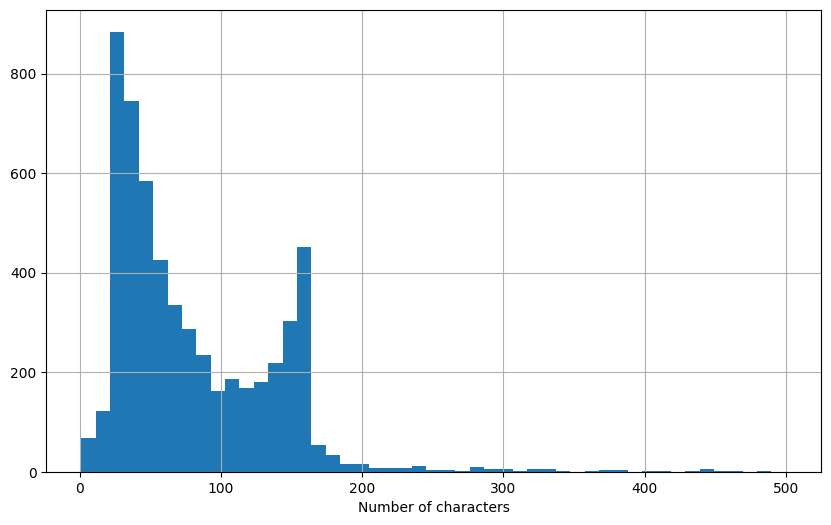

In [11]:
data_df.msg_len.hist(bins=np.linspace(1,500, 50), figsize=figsize_default)
plt.gca().set_xlabel("Number of characters");

* Looks quite bimodel, let's check if there is a dependence on spam/ham

<Axes: xlabel='msg_len', ylabel='Count'>

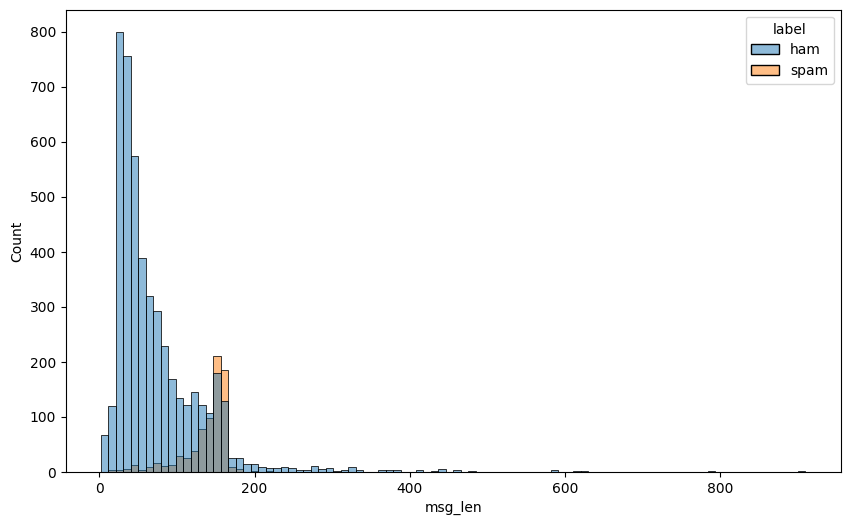

In [12]:
plt.figure(figsize=figsize_default)
sb.histplot(data=data_df, x="msg_len", hue="label")

In [13]:
data_df.groupby("label").msg_len.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4827.0,71.440025,58.322011,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.634538,28.854103,13.0,133.0,149.0,157.0,223.0


* Indeed, spam messages are on average longer

In [14]:
# a few more simple features based on counting
data_df["n_exclamations"] = data_df.text.str.count("!")
data_df["n_urls"] = data_df.text.str.lower().str.count("www.")
data_df["n_free"] = data_df.text.str.lower().str.count("free ")

In [15]:
data_df.groupby("label").n_exclamations.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4827.0,0.176507,0.605886,0.0,0.0,0.0,0.0,11.0
spam,747.0,0.729585,0.942997,0.0,0.0,0.0,1.0,5.0


In [16]:
data_df.groupby("label").n_urls.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4827.0,0.000622,0.024925,0.0,0.0,0.0,0.0,1.0
spam,747.0,0.131191,0.337836,0.0,0.0,0.0,0.0,1.0


In [17]:
data_df.groupby("label").n_free.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4827.0,0.009115,0.097204,0.0,0.0,0.0,0.0,2.0
spam,747.0,0.243641,0.530134,0.0,0.0,0.0,0.0,3.0


* So, spam message do also have, on average, distinct differences in the few features we looked at. However, in the following, we are trying to combine all of this information and more in an ML system, rather than manually examining differences of particular distributions.

## Trying a "classical" ML classification

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, make_scorer
from xgboost import XGBClassifier
from sms_classification.utils import create_pipeline

In [19]:
# using some reasonable hyperparameters based on my experience, will skip hyperparameter tuning for now as it's usually a minor impact
models = {"logistic": LogisticRegression(random_state=42),
          "randomforest": RandomForestClassifier(n_estimators=150, random_state=42),
          "extratress": ExtraTreesClassifier(n_estimators=150, random_state=42),
          "xgb": XGBClassifier(random_state=42),
          "logistic_balanced": LogisticRegression(class_weight="balanced", random_state=42),
          "randomforest_balanced": RandomForestClassifier(n_estimators=150, class_weight="balanced", random_state=42),
          "extratress_balanced": ExtraTreesClassifier(n_estimators=150, class_weight="balanced", random_state=42)}

In [20]:
data_df.columns

Index(['label', 'text', 'msg_len', 'n_exclamations', 'n_urls', 'n_free'], dtype='object')

In [21]:
# we'll define which numerical and text features to use
num_cols = ["msg_len", "n_exclamations", "n_urls", "n_free"]
text_col = "text"

In [22]:
pipeline = create_pipeline(models["logistic"], num_cols, text_col)

In [23]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['msg_len', 'n_exclamations',
                                                   'n_urls', 'n_free']),
                                                 ('text',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'text')])),
                ('classifier', LogisticRegression(random_state=42))])

* The general idea behind Tfidf is to have numerical features for words/entities in a sentence that represent how frequent a certain word is in a sentence normalized to how frequent it is overall in the corpus of all sentences. A high value will then on average indicate higher discrimination power for a certain label, if we see similar patterns among other sentences.

In [24]:
data_df[num_cols + [text_col]].shape

(5574, 5)

In [25]:
sel_data_df = data_df[num_cols + [text_col]]
labels = data_df["label"]
labels_int = labels.map({"spam": 1, "ham": 0})

In [26]:
labels_int.value_counts()

label
0    4827
1     747
Name: count, dtype: int64

In [27]:
# Split the data for a quick test prior to CV
X_train, X_test, y_train, y_test = train_test_split(
    sel_data_df,
    labels_int,
    test_size=0.2,
    random_state=42
)

In [28]:
X_train.shape, y_train.shape

((4459, 5), (4459,))

In [29]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['msg_len', 'n_exclamations',
                                                   'n_urls', 'n_free']),
                                                 ('text',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'text')])),
                ('classifier', LogisticRegression(random_state=42))])

In [30]:
def check_text_features(messages: pd.Series, labels: pd.Series, pipeline, msg_print: int = 3):
    """
    Manually check text features for a given set of messages
    """
    # Transform the messages
    transformed = pipeline.named_steps["preprocessor"]['text'].transform(messages)
    feature_matrix = transformed.toarray()
    
    # Get feature names
    feature_names = pipeline.named_steps["preprocessor"]['text'].get_feature_names_out()
    
    # Print feature information
    print(f"\nFeature matrix shape: {feature_matrix.shape}")
    print(f"Number of unique features (for text encoding only): {feature_matrix.shape[1]}")
    
    # Show top features for top x messages
    for i_msg in range(msg_print):
        first_message_features = feature_matrix[i_msg]
        top_features = np.argsort(first_message_features)[-5:]  # Get top 5 features
        
        print(f"\nTop features in message {i_msg + 1} (label: {labels[i_msg]}):")
        for idx in top_features[::-1]:
            print(f"Feature '{feature_names[idx]}': {first_message_features[idx]:.3f}")

# Check training set features
print("\nChecking training set features:")
check_text_features(X_train["text"], y_train, pipeline)


Checking training set features:

Feature matrix shape: (4459, 7463)
Number of unique features (for text encoding only): 7463

Top features in message 1 (label: 0):
Feature 'pic': 0.403
Feature 'wk': 0.358
Feature 'pocketbabe': 0.247
Feature '89080': 0.247
Feature 'george': 0.247

Top features in message 2 (label: 0):
Feature 'epsilon': 0.566
Feature 'armand': 0.531
Feature 'ass': 0.466
Feature 'says': 0.424
Feature 'elaine': 0.000

Top features in message 3 (label: 1):
Feature 'balloon': 0.617
Feature 'air': 0.528
Feature 'hot': 0.450
Feature 'lol': 0.372
Feature 'elaya': 0.000


In [31]:
# naive accuracy for comparison: if we always predicted "ham" / 0
print(f"Naive accuracy: {np.sum(labels_int == 0)/labels_int.shape[0]}")

Naive accuracy: 0.8659849300322928


In [64]:
# define all metrics we want to calculate
scoring_dict_raw = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'roc_auc': roc_auc_score
}


scoring_dict = {n: make_scorer(f) for n, f in scoring_dict_raw.items()}


all_results = pd.DataFrame()
n_cv = 5

# try different models
for model_name, model in models.items():
    print(f"\nResults for {model_name}:")
    pipeline = create_pipeline(model, num_cols, text_col)
    
    cv_results = cross_validate(pipeline, sel_data_df, labels_int, cv=n_cv, scoring=scoring_dict)
    cv_results["model"] = [model_name] * n_cv

    print(cv_results)

    all_results = pd.concat([all_results, pd.DataFrame(cv_results)])


Results for logistic:
{'fit_time': array([0.09702325, 0.10368776, 0.10844016, 0.11627221, 0.11497974]), 'score_time': array([0.02922082, 0.02937126, 0.02837276, 0.02843952, 0.02900791]), 'test_accuracy': array([0.97399103, 0.96143498, 0.94977578, 0.96412556, 0.96947935]), 'test_precision': array([0.98387097, 0.93442623, 0.8852459 , 0.97413793, 0.96      ]), 'test_recall': array([0.81879195, 0.76510067, 0.72      , 0.75333333, 0.80536913]), 'test_f1': array([0.89377289, 0.84132841, 0.79411765, 0.84962406, 0.87591241]), 'test_roc_auc': array([0.90836078, 0.87840955, 0.85274611, 0.87511226, 0.90009389]), 'model': ['logistic', 'logistic', 'logistic', 'logistic', 'logistic']}

Results for randomforest:
{'fit_time': array([1.300174  , 1.24828339, 1.26009345, 1.20909166, 1.30476546]), 'score_time': array([0.06371999, 0.06101894, 0.06171656, 0.06084633, 0.06684923]), 'test_accuracy': array([0.98295964, 0.97399103, 0.97578475, 0.97130045, 0.97755835]), 'test_precision': array([1.        , 0.99

In [33]:
display(all_results.head(10))

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,model
0,0.141431,0.029987,0.973991,0.983871,0.818792,0.893773,0.908361,logistic
1,0.111418,0.028764,0.961435,0.934426,0.765101,0.841328,0.878410,logistic
2,0.115190,0.029048,0.949776,0.885246,0.720000,0.794118,0.852746,logistic
3,0.119796,0.028529,0.964126,0.974138,0.753333,0.849624,0.875112,logistic
4,0.132707,0.029251,0.969479,0.960000,0.805369,0.875912,0.900094,logistic
0,1.334804,0.067061,0.982960,1.000000,0.872483,0.931900,0.936242,randomforest
1,1.279082,0.062309,0.973991,0.991803,0.812081,0.892989,0.905523,randomforest
2,1.238274,0.062000,0.975785,1.000000,0.820000,0.901099,0.910000,randomforest
3,1.248246,0.061540,0.971300,0.975806,0.806667,0.883212,0.901779,randomforest
4,1.285110,0.061735,0.977558,1.000000,0.832215,0.908425,0.916107,randomforest


In [34]:
all_results_melt = pd.melt(all_results, id_vars=["model"], 
                           value_vars=[f"test_{metric}" for metric in scoring_dict.keys()], 
                           var_name="metric",
                           value_name="metric_value")

display(all_results_melt.head(10))

,model,metric,metric_value
0,logistic,test_accuracy,0.973991
1,logistic,test_accuracy,0.961435
2,logistic,test_accuracy,0.949776
3,logistic,test_accuracy,0.964126
4,logistic,test_accuracy,0.969479
5,randomforest,test_accuracy,0.982960
6,randomforest,test_accuracy,0.973991
7,randomforest,test_accuracy,0.975785
8,randomforest,test_accuracy,0.971300
9,randomforest,test_accuracy,0.977558


<Figure size 1000x600 with 0 Axes>

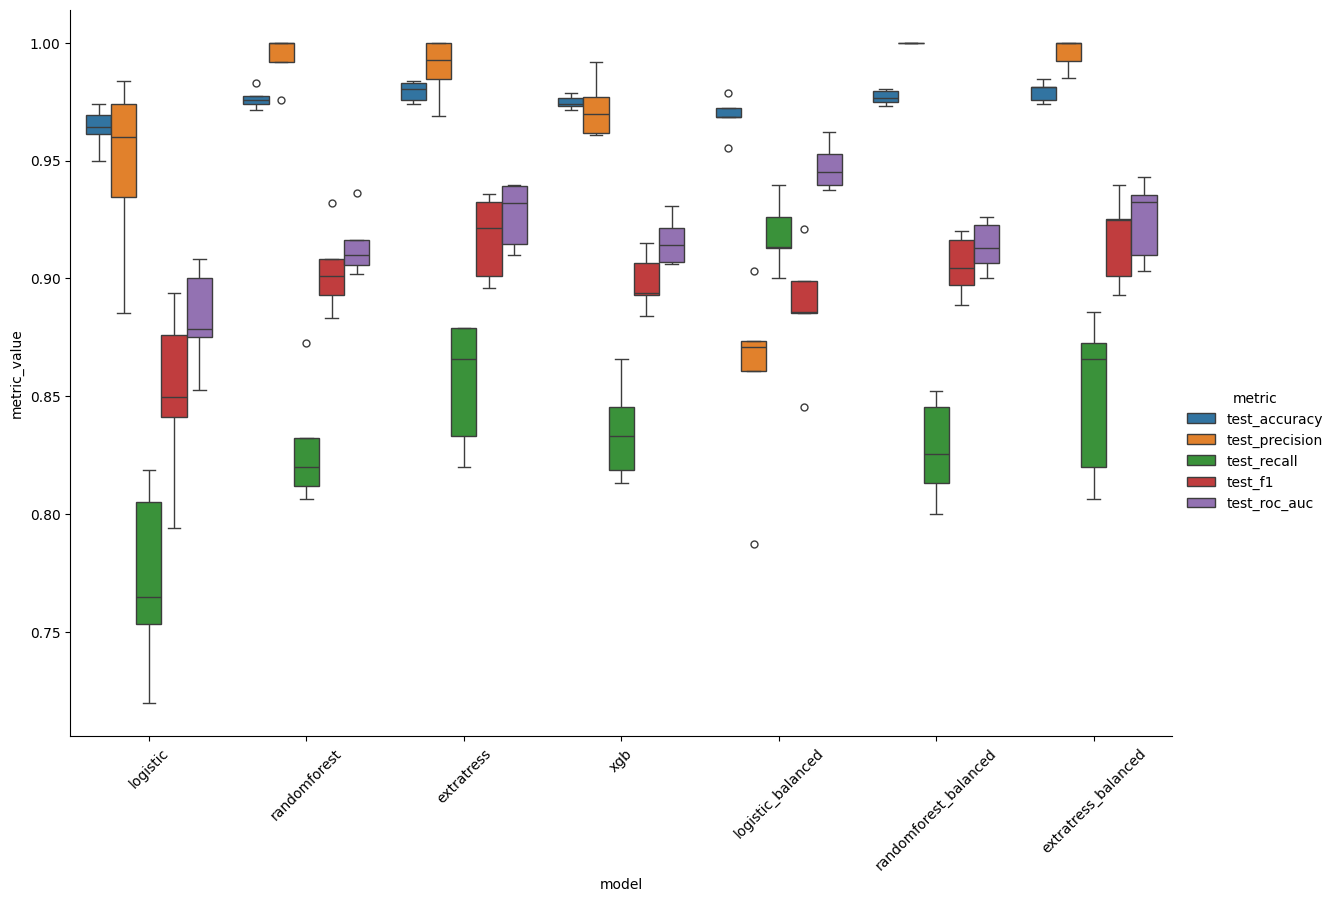

In [35]:
plt.figure(figsize=figsize_default)
sb.catplot(data=all_results_melt, x="model", y="metric_value", hue="metric", kind="box", height=8, aspect=1.5)
plt.xticks(rotation=45);

## Trying naive LLM approach

In [45]:
from transformers import pipeline
import torch
from collections import defaultdict

In [54]:
torch.cuda.is_available()

False

In [37]:
# Initialize the zero-shot classifier using bart model from FB
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

/home/alex/code/sms_spam_classification/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Device set to use cpu


In [55]:
# helper function
def classify_helper(texts: List[str], labels: list = ["spam", "legitimate"], add_context: str=None) -> pd.DataFrame:
    new_texts = []
    if add_context:
        for text in texts:
            new_texts.append(f"{add_context}{text}")
        texts = new_texts

    # call LLM model
    results = classifier(texts, labels)
    
    # reformatting
    result_dict = defaultdict(list)
    for result in results:
        result_dict["text"].append(result["sequence"])
        for label in labels:
            result_dict[label].append(result["scores"][result["labels"].index(label)])
    return pd.DataFrame(result_dict)

In [56]:
add_context = """
The following sms message was received. 
Please assess and classify if it seems in any way like a spam message or not.
Return spam if it does and legitimate if not."
"""

llm_res_df = classify_helper(sel_data_df.text.to_list(), 
                             add_context=None)
llm_res_df["is_spam"] = (llm_res_df["spam"] >= llm_res_df["legitimate"]).astype(int)

In [57]:
llm_res_df.head(20)

,text,spam,legitimate,is_spam
0,"Go until jurong point, crazy.. Available only ...",0.378410,0.621590,0
1,Ok lar... Joking wif u oni...,0.714071,0.285929,1
2,Free entry in 2 a wkly comp to win FA Cup fina...,0.106996,0.893004,0
3,U dun say so early hor... U c already then say...,0.287092,0.712908,0
4,"Nah I don't think he goes to usf, he lives aro...",0.156114,0.843886,0
5,FreeMsg Hey there darling it's been 3 week's n...,0.275630,0.724370,0
6,Even my brother is not like to speak with me. ...,0.112035,0.887965,0
7,As per your request 'Melle Melle (Oru Minnamin...,0.059958,0.940042,0
8,WINNER!! As a valued network customer you have...,0.014661,0.985339,0
9,Had your mobile 11 months or more? U R entitle...,0.018012,0.981988,0


* Let's check the metrics from before

In [65]:
for score_name, score_fct in scoring_dict_raw.items():
    print(f"{score_name:} {score_fct(labels_int, llm_res_df.is_spam.values)}")

accuracy 0.8266953713670614
precision 0.17117117117117117
recall 0.07630522088353414
f1 0.10555555555555556
roc_auc 0.5095634246120592
